<center> <h1> Neural activity embeddings </h1> </center>

### Imports & settings

In [1]:
from mouse_brain.data_preprocess.data import *
from mouse_brain.models.embedding import *
from mouse_brain.utils.embedding_training import *
from mouse_brain.utils.evaluations import *
from mouse_brain.data_preprocess.utils import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import KernelPCA
import umap

/home/cossart/anaconda3/envs/mohsine_env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/cossart/anaconda3/envs/mohsine_env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/cossart/anaconda3/envs/mohsine_env/lib/python3.11/si

In [2]:
suite_2p_folder = "/home/cossart/Activity_MVT/Data/2023-04-10_a/suite2p"
movement_amplitude_path = "/home/cossart/Activity_MVT/From_activity_to_mouvment/frame_diff.npy"
device = 'cuda' if torch.cuda.is_available else 'cpu'

### Data

In [3]:
mvt_ampl = np.load(movement_amplitude_path).astype(np.float32)

mvt_ampl = (mvt_ampl - np.min(mvt_ampl))/(np.max(mvt_ampl) - np.min(mvt_ampl))

#The fluoresence activity
Fluo = np.load(os.path.join(suite_2p_folder, "plane0/F.npy"))

#The probability of each actitvity being a cell
is_cell = np.load(os.path.join(suite_2p_folder, "plane0/iscell.npy"))

#The probability threhold
probability = 0.95

#The selected cells using the threhold
cells_actvities = Fluo[np.where(is_cell[:,1]>probability)][:, :mvt_ampl.shape[0]]

# Z-score normalization x_norm = (x-mean)/std
cells_actvities = (cells_actvities - np.mean(cells_actvities, axis=1)[:, np.newaxis])/np.std(cells_actvities, axis=1)[:, np.newaxis] 

In [4]:
train_loader, val_loader, test_loader = make_embedding_loaders(suite_2p_folder, mvt_ampl, test_size=0.3, val_size=0.1, shift=0, discret_label=True)

- The number of ROI that are considered as cell with a probability higher than 0.95 is: 325
- The mouvement amplitude mean: 0.46662587 , std: 0.09864493


In [6]:
n_features = 325
embedding_dim = 2
seq_len = 10

In [6]:
train_seq_loader, val_seq_loader, test_seq_loader = make_sequential_embedding_loaders(suite_2p_folder, mvt_ampl, seq_len, test_size=0.3, val_size=0.1, shift=0, discret_label=True)

- The number of ROI that are considered as cell with a probability higher than 0.95 is: 325
- The mouvement amplitude mean: 0.46662587 , std: 0.09864493


In [4]:
train_tr_loader, val_tr_loader, test_tr_loader = make_transformer_embedding_loaders(suite_2p_folder, mvt_ampl, 50, test_size=0.3, val_size=0.1, shift=0, discret_label=False)

- The number of ROI that are considered as cell with a probability higher than 0.95 is: 325
- The mouvement amplitude mean: 0.46662587 , std: 0.09864493


### Methods

In [8]:
#PCA
num_components = 2

pca = PCA(n_components=num_components)

pca_result = pca.fit_transform(cells_actvities.T)

In [9]:
#ICA
ica = FastICA(n_components=2)

ica_result = ica.fit_transform(cells_actvities.T)

In [10]:
#t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)

tsne_result = tsne.fit_transform(cells_actvities.T)

In [11]:
#UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)

umap_result = umap_model.fit_transform(cells_actvities.T)

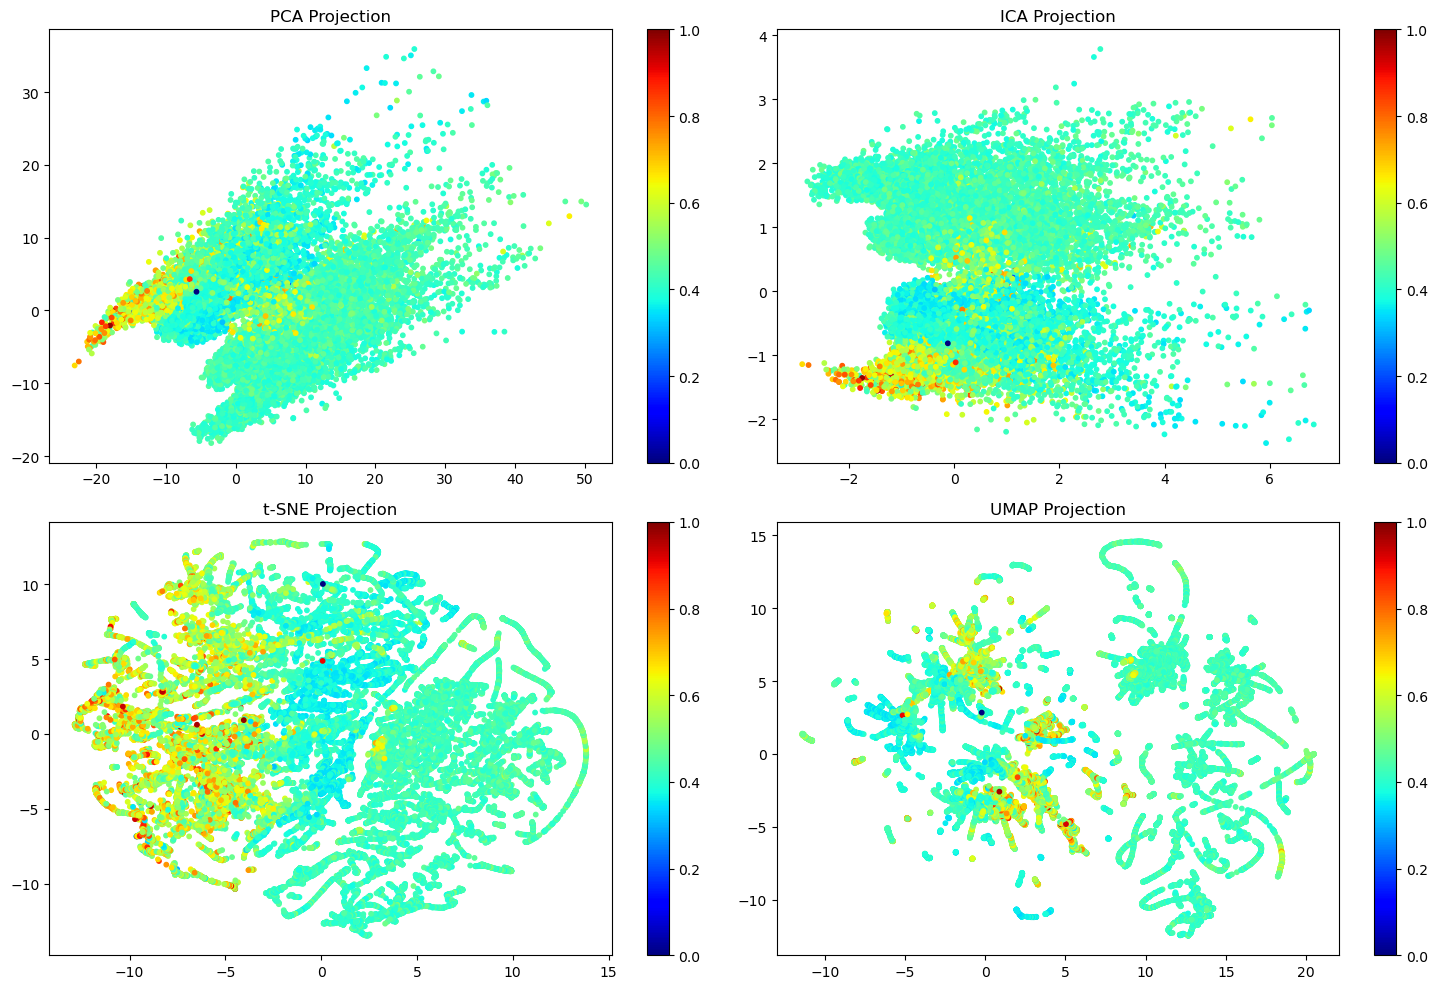

In [12]:
# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot PCA projection in the first subplot (upper left)
sc1 = axs[0, 0].scatter(pca_result[:, 0], pca_result[:, 1], c=mvt_ampl, cmap='jet', s=10)
axs[0, 0].set_title('PCA Projection')
fig.colorbar(sc1, ax=axs[0, 0])

# Plot ICA projection in the second subplot (upper right)
sc2 = axs[0, 1].scatter(ica_result[:, 0], ica_result[:, 1], c=mvt_ampl, cmap='jet', s=10)
axs[0, 1].set_title('ICA Projection')
fig.colorbar(sc2, ax=axs[0, 1])

# Plot t-SNE projection in the third subplot (lower left)
sc3 = axs[1, 0].scatter(tsne_result[:, 0], tsne_result[:, 1], c=mvt_ampl, cmap='jet', s=10)
axs[1, 0].set_title('t-SNE Projection')
fig.colorbar(sc3, ax=axs[1, 0])

# Plot UMAP projection in the fourth subplot (lower right)
sc4 = axs[1, 1].scatter(umap_result[:, 0], umap_result[:, 1], c=mvt_ampl, cmap='jet', s=10)
axs[1, 1].set_title('UMAP Projection')
fig.colorbar(sc4, ax=axs[1, 1])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [13]:
#Auto encoder
ae = AutoEncoder(n_features, embedding_dim, 3).to(device)

In [14]:
#Create the optimizer of the auto encoder
optimizer = torch.optim.Adam(ae.parameters())

#Use the absolute value insteade of the square error
criterion = nn.L1Loss(reduction='mean').to(device)

In [15]:
history = train_model(ae, optimizer, criterion, train_loader, val_loader, 10, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1  train loss: 0.04157043616894795  val loss: 0.03660650923848152  time: 1.5385875701904297 
Epoch: 2  train loss: 0.036216419230660664  val loss: 0.036585732230118344  time: 0.8512570858001709 
Epoch: 3  train loss: 0.03621250994341529  val loss: 0.0364595465362072  time: 0.8713171482086182 
Epoch: 4  train loss: 0.03619301151079328  val loss: 0.03639118320175579  time: 0.7487082481384277 
Epoch: 5  train loss: 0.03616882739183695  val loss: 0.0364077485033444  time: 0.7939932346343994 
Epoch: 6  train loss: 0.036155740244557026  val loss: 0.036364348605275154  time: 0.863375186920166 
Epoch: 7  train loss: 0.036163294789097876  val loss: 0.03659346327185631  time: 0.8677287101745605 
Epoch: 8  train loss: 0.0361099396224903  val loss: 0.036462338641285896  time: 0.8907520771026611 
Epoch: 9  train loss: 0.036118100923688515  val loss: 0.036329910957387516  time: 0.8311340808868408 
Epoch: 10  train loss: 0.03609960838018552  val loss: 0.03651781938970089  time: 0.8094213008880

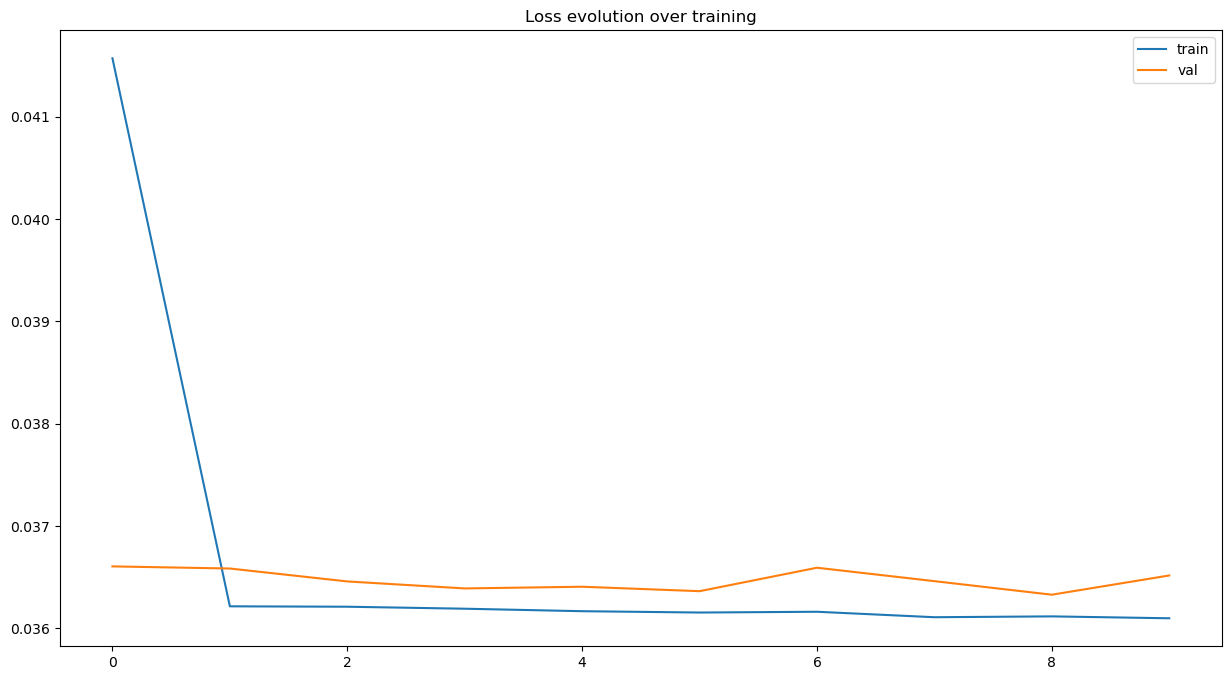

In [16]:
plt.figure(figsize=(15, 8))
plt.plot(history['train'], label='train')
plt.plot(history['val'], label='val')
plt.title("Loss evolution over training")
plt.legend()

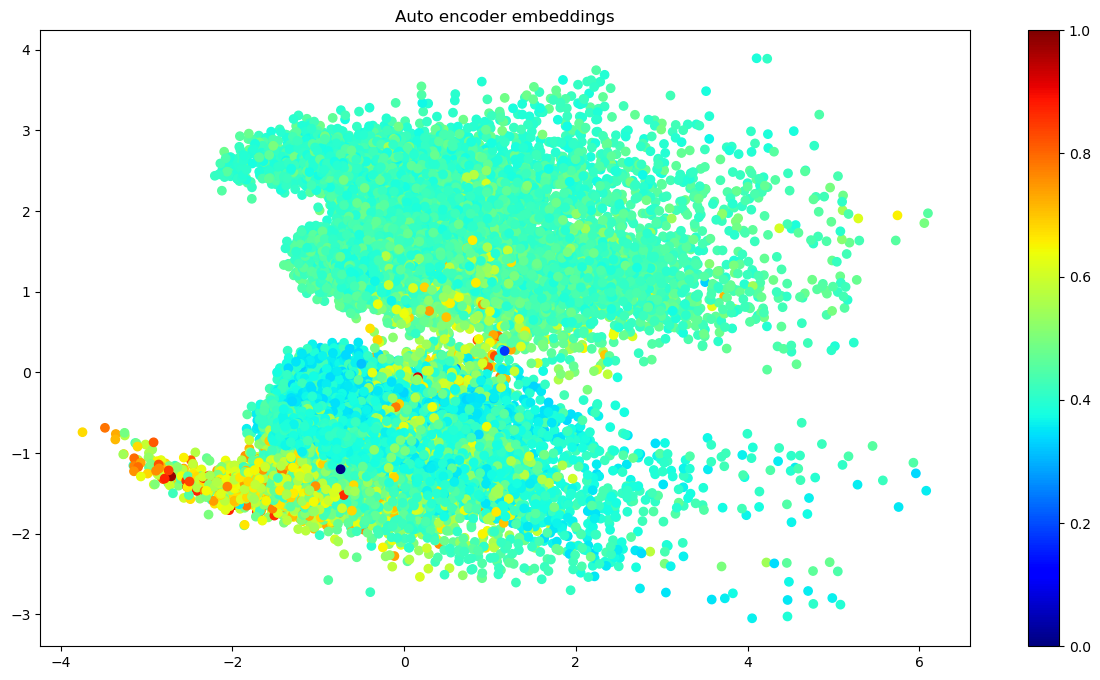

In [17]:
X = torch.Tensor(cells_actvities.T).to(torch.float32).to(device)
latents = ae.encoder(X).cpu().detach().numpy()

plt.figure(figsize=(15, 8))
plt.scatter(latents[:, 0], latents[:, 1], c=mvt_ampl, cmap='jet')
plt.title("Auto encoder embeddings")
plt.colorbar()

In [18]:
# Create a KernelPCA instance
kernel_pca_model = KernelPCA(kernel='rbf', gamma=0.1, n_components=2)

# Fit and transform the data
kpca_results = kernel_pca_model.fit_transform(cells_actvities.T)

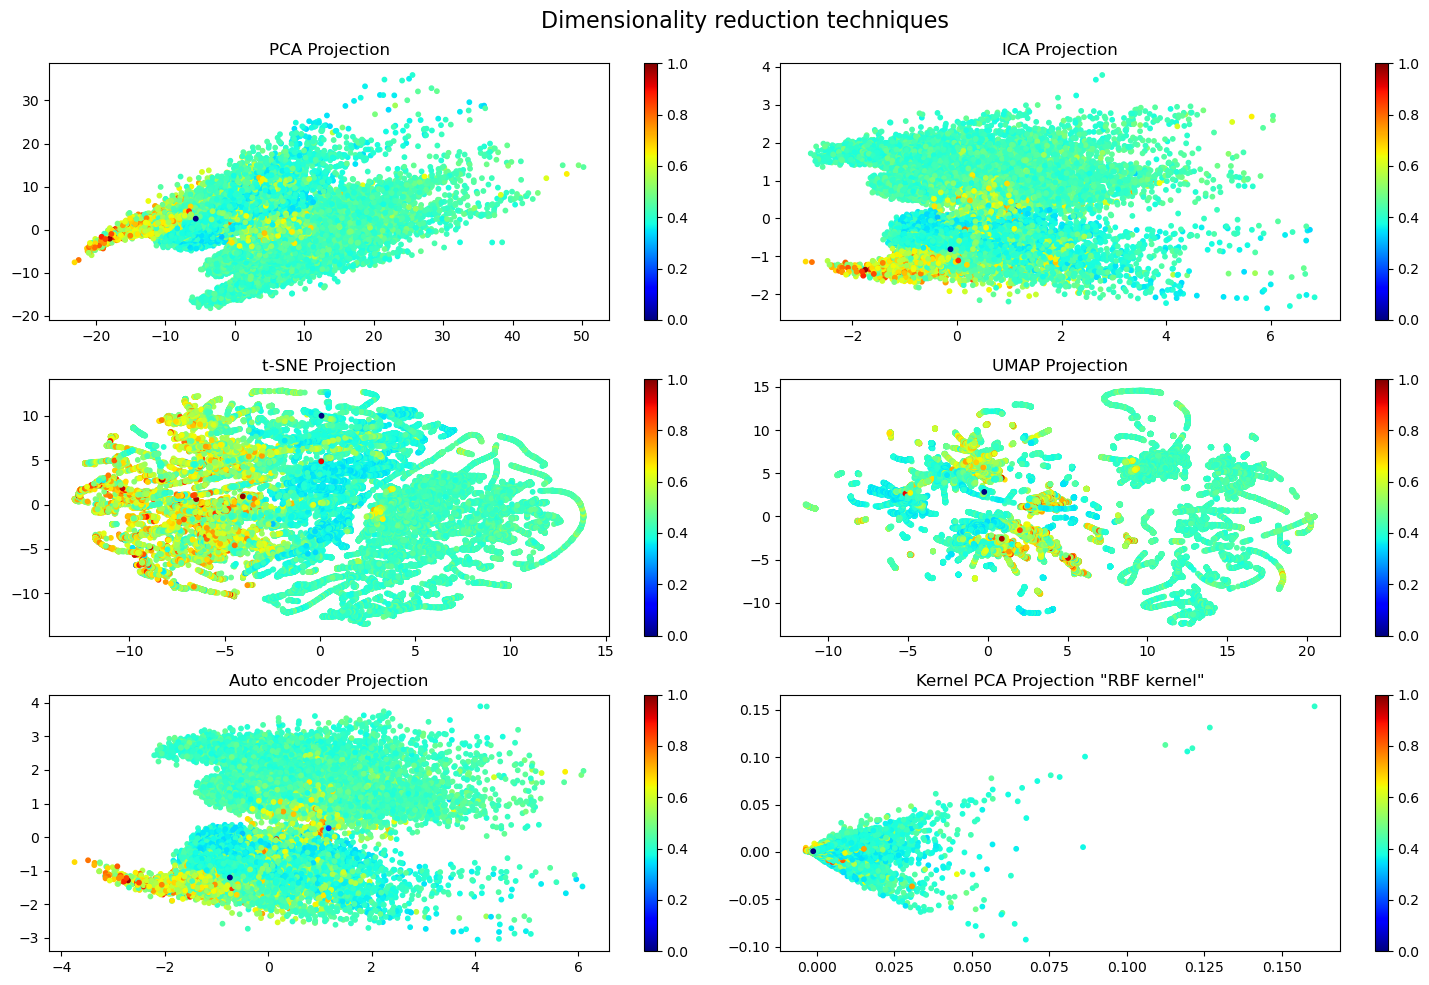

In [21]:
fig, axs = plt.subplots(3, 2, figsize=(15, 10))

# Plot PCA projection in the first subplot (upper left)
sc1 = axs[0, 0].scatter(pca_result[:, 0], pca_result[:, 1], c=mvt_ampl, cmap='jet', s=10)
axs[0, 0].set_title('PCA Projection')
fig.colorbar(sc1, ax=axs[0, 0])

# Plot ICA projection in the second subplot (upper right)
sc2 = axs[0, 1].scatter(ica_result[:, 0], ica_result[:, 1], c=mvt_ampl, cmap='jet', s=10)
axs[0, 1].set_title('ICA Projection')
fig.colorbar(sc2, ax=axs[0, 1])

# Plot t-SNE projection in the third subplot (lower left)
sc3 = axs[1, 0].scatter(tsne_result[:, 0], tsne_result[:, 1], c=mvt_ampl, cmap='jet', s=10)
axs[1, 0].set_title('t-SNE Projection')
fig.colorbar(sc3, ax=axs[1, 0])

# Plot UMAP projection in the fourth subplot (lower right)
sc4 = axs[1, 1].scatter(umap_result[:, 0], umap_result[:, 1], c=mvt_ampl, cmap='jet', s=10)
axs[1, 1].set_title('UMAP Projection')
fig.colorbar(sc4, ax=axs[1, 1])

# Plot UMAP projection in the fourth subplot (lower right)
sc5 = axs[2, 0].scatter(latents[:, 0], latents[:, 1], c=mvt_ampl, cmap='jet', s=10)
axs[2, 0].set_title('Auto encoder Projection')
fig.colorbar(sc5, ax=axs[2, 0])

# Plot UMAP projection in the fourth subplot (lower right)
sc6 = axs[2, 1].scatter(kpca_results[:, 0], kpca_results[:, 1], c=mvt_ampl, cmap='jet', s=10)
axs[2, 1].set_title('Kernel PCA Projection "RBF kernel"')
fig.colorbar(sc5, ax=axs[2, 1])


fig.suptitle('Dimensionality reduction techniques', fontsize=16)

# Adjust layout
plt.tight_layout()

# Show the plot
#plt.show()

plt.savefig('dim_red.png', bbox_inches='tight')

### Sequential embedding

In [108]:
# Initiate the model
rae = RecurrentAutoencoder(seq_len, n_features, embedding_dim, n_layers=1)

#Put the model to the device
rae = rae.to(device)

#Create the optimizer of the auto encoder
optimizer = torch.optim.Adam(rae.parameters())

#Use the absolute value insteade of the square error
criterion = nn.L1Loss(reduction='mean').to(device)

In [109]:
history = train_model(rae, optimizer, criterion, train_seq_loader, val_seq_loader, 50, device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 5  train loss: 0.043940995232728514  val loss: 0.0434279524322067  time: 1.9709374904632568 
Epoch: 10  train loss: 0.04139249850793377  val loss: 0.04058291417147432  time: 2.0394582748413086 
Epoch: 15  train loss: 0.038902903927247164  val loss: 0.03847876191139221  time: 1.792409896850586 
Epoch: 20  train loss: 0.0384623900298839  val loss: 0.038019802421331406  time: 1.9295234680175781 
Epoch: 25  train loss: 0.03702873708275349  val loss: 0.036582685208746364  time: 1.961381196975708 
Epoch: 30  train loss: 0.03641705040860435  val loss: 0.036105201446584294  time: 1.906294822692871 
Epoch: 35  train loss: 0.036305478429826704  val loss: 0.036014318998370855  time: 2.050081491470337 
Epoch: 40  train loss: 0.0361775282729903  val loss: 0.03587557588304792  time: 1.9524426460266113 
Epoch: 45  train loss: 0.03589406496156817  val loss: 0.03558475737060819  time: 1.89723801612854 
Epoch: 50  train loss: 0.035563224562160344  val loss: 0.03528359053390367  time: 1.7849414348

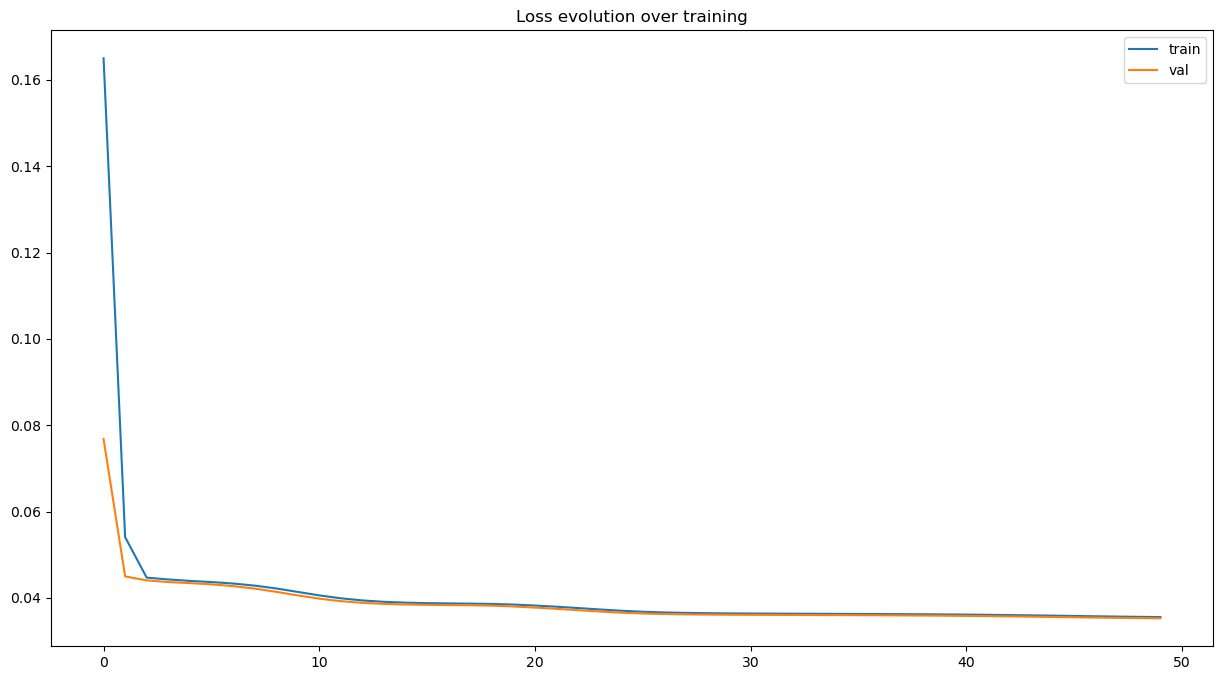

In [110]:
plt.figure(figsize=(15, 8))
plt.plot(history['train'], label='train')
plt.plot(history['val'], label='val')
plt.title("Loss evolution over training")
plt.legend()

In [111]:
X = create_sequences(cells_actvities.T, seq_len)

X = torch.Tensor(X).to(torch.float32).to(device)

latents = rae.encoder(X).cpu().detach().numpy()

In [112]:
latents.shape

(35989, 2)

In [113]:
mvt_ampl[:-seq_len].shape

(35988,)

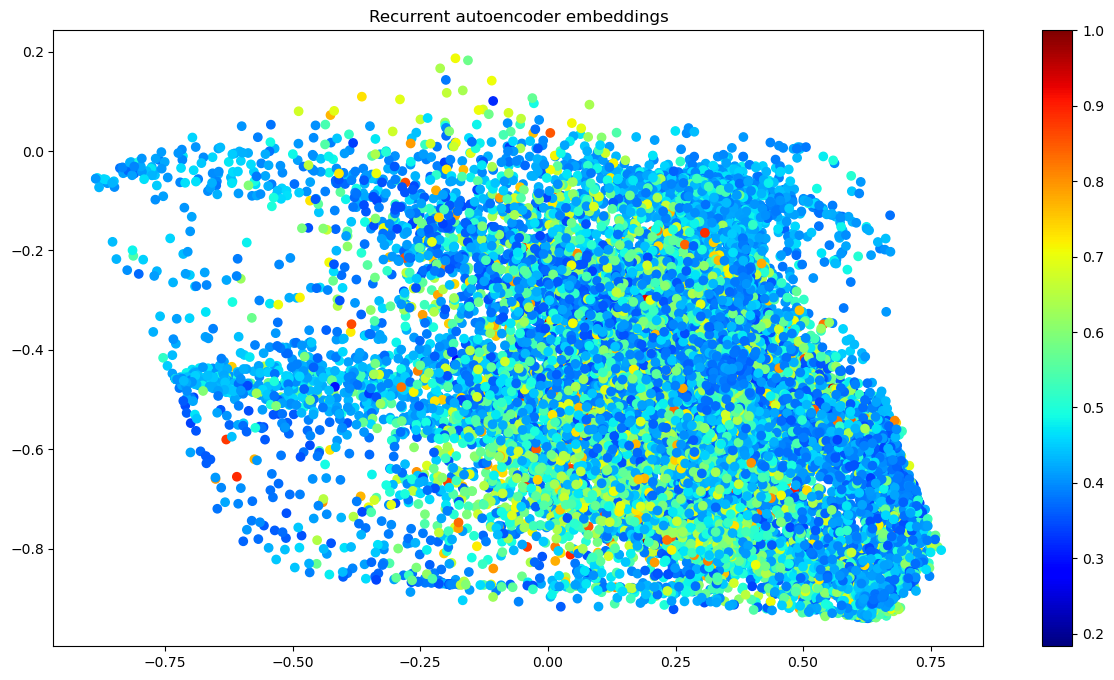

In [114]:
plt.figure(figsize=(15, 8))
plt.scatter(latents[:, 0], latents[:, 1], c=mvt_ampl[:-seq_len+1], cmap='jet')
plt.title("Recurrent autoencoder embeddings")
plt.colorbar()

### Training with inference

In [115]:
iae = Inference_AutoEncoder(n_features, embedding_dim, 3, n_classes=1)

iae.to(device)

#Create the optimizer of the auto encoder
optimizer = torch.optim.Adam(iae.parameters())

#Use the absolute value insteade of the square error
criterion1 = nn.L1Loss(reduction='mean').to(device)

criterion2 = nn.BCEWithLogitsLoss().to(device)

In [116]:
history = train_inference_model(iae, optimizer, criterion1, criterion2, 1, train_loader, val_loader, 20, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2  train reconstruction loss: 0.0401984179675903  val reconstruction loss: 0.04038986191153526  time: 1.21669602394104 
Epoch: 4  train reconstruction loss: 0.039268046556769506  val reconstruction loss: 0.03988928294607571  time: 1.2585361003875732 
Epoch: 6  train reconstruction loss: 0.038879322819411755  val reconstruction loss: 0.03960320672818592  time: 1.283095121383667 
Epoch: 8  train reconstruction loss: 0.038653638639041914  val reconstruction loss: 0.03889031096228531  time: 1.2722764015197754 
Epoch: 10  train reconstruction loss: 0.038496139904727104  val reconstruction loss: 0.03954901599458286  time: 1.2579667568206787 
Epoch: 12  train reconstruction loss: 0.03835874273563209  val reconstruction loss: 0.03879847936332226  time: 1.165917158126831 
Epoch: 14  train reconstruction loss: 0.03820949175354579  val reconstruction loss: 0.039850830499614985  time: 1.143838882446289 
Epoch: 16  train reconstruction loss: 0.038165589389593704  val reconstruction loss: 0.0

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(history['train_reconstruction'], label='train')
plt.plot(history['val_reconstruction'], label='val')
plt.title("Reconsturction Loss evolution over training")
plt.legend()

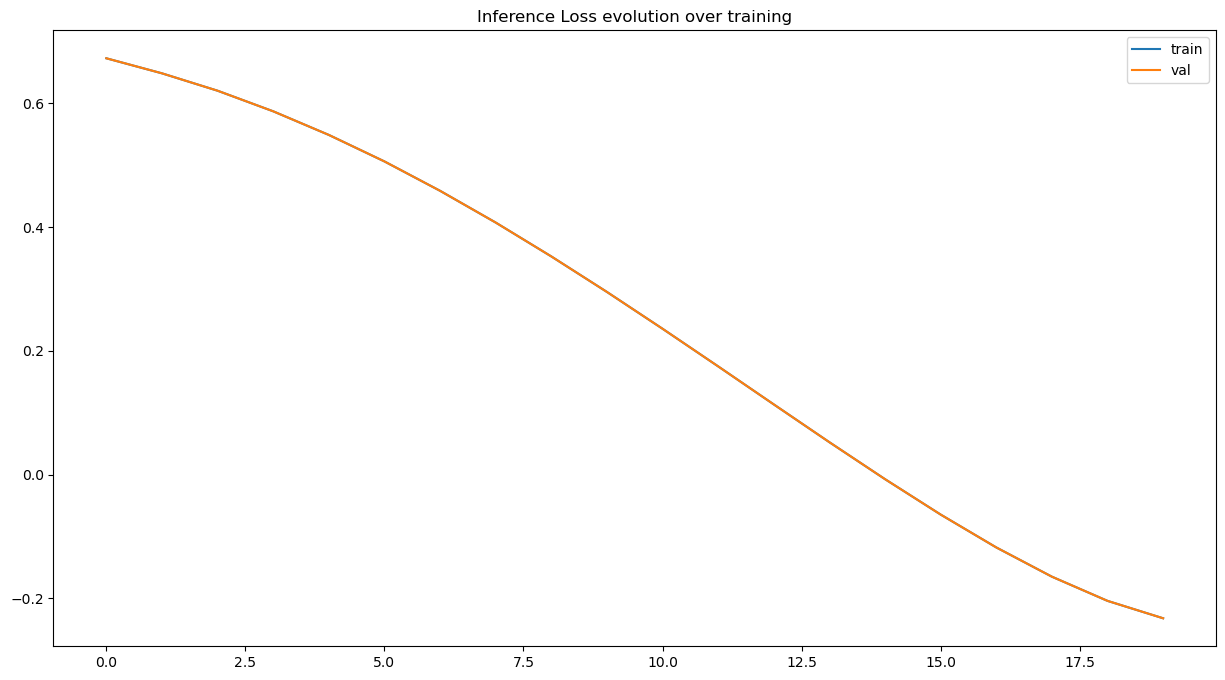

In [118]:
plt.figure(figsize=(15, 8))
plt.plot(history['train_inference'], label='train')
plt.plot(history['train_inference'], label='val')
plt.title("Inference Loss evolution over training")
plt.legend()

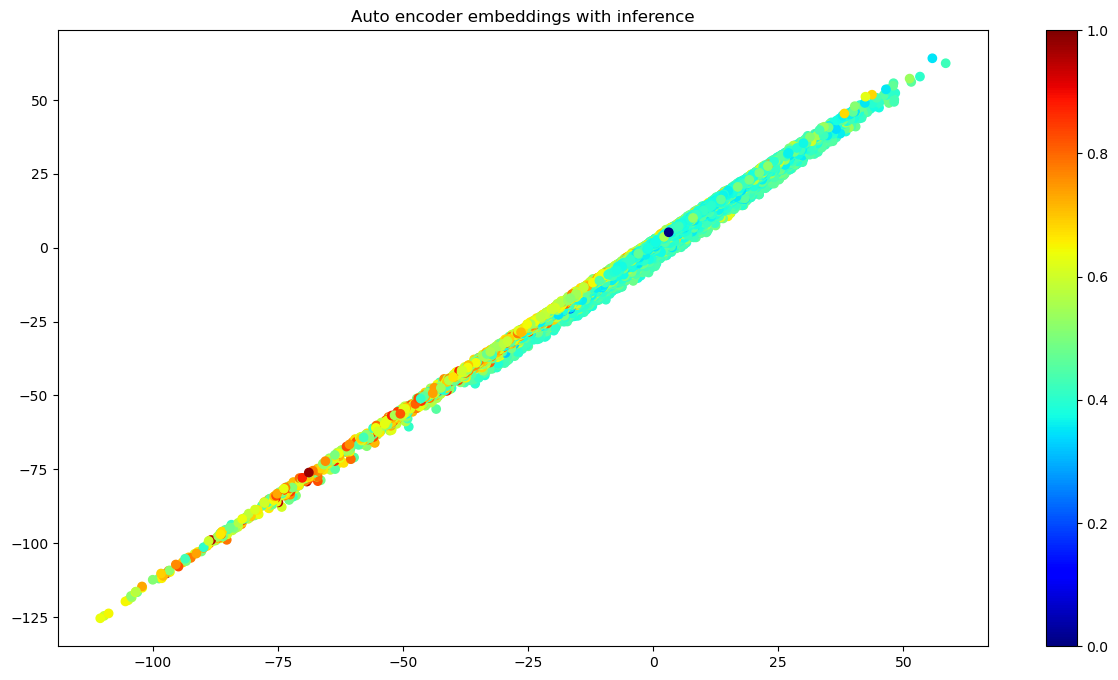

In [119]:
X = torch.Tensor(cells_actvities.T).to(torch.float32).to(device)
latents = iae.encoder(X).cpu().detach().numpy()

plt.figure(figsize=(15, 8))
plt.scatter(latents[:, 0], latents[:, 1], c=mvt_ampl, cmap='jet')
plt.title("Auto encoder embeddings with inference")
plt.colorbar()

In [120]:
#LDA
mvt_labels = np.array(mvt_ampl >  np.mean(mvt_ampl) + 3 * np.std(mvt_ampl), dtype=int)

In [121]:
lda = LinearDiscriminantAnalysis(n_components=1)

lda_result = lda.fit_transform(cells_actvities.T, mvt_labels)

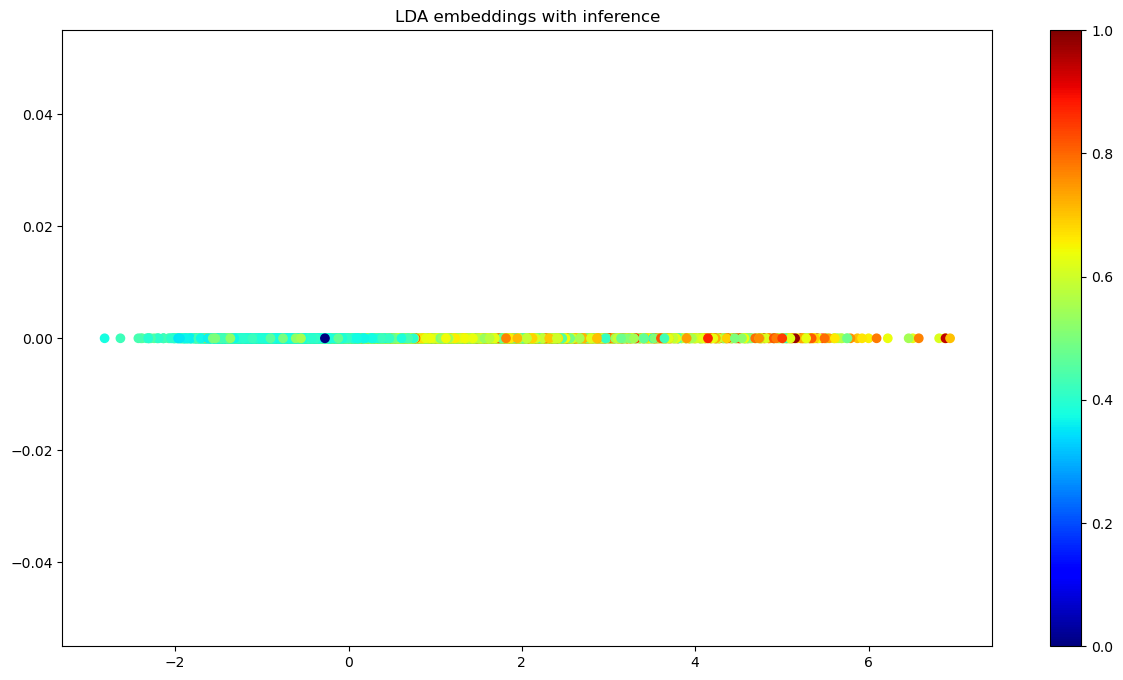

In [122]:
plt.figure(figsize=(15, 8))
plt.scatter(lda_result, np.zeros_like(lda_result), c=mvt_ampl, cmap='jet')
plt.title("LDA embeddings with inference")
plt.colorbar()

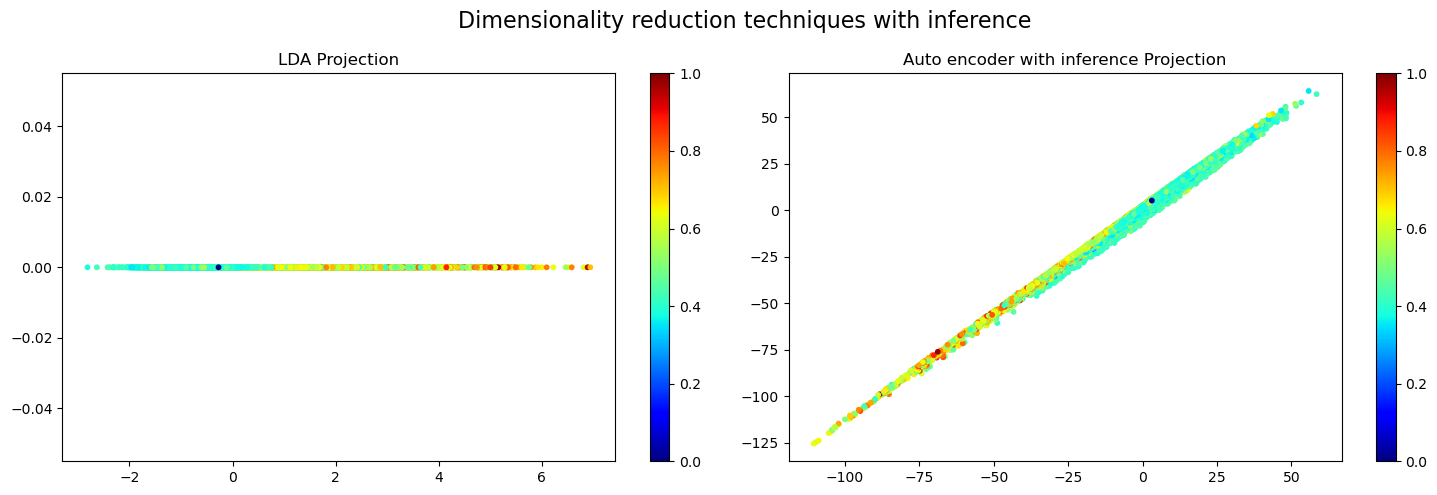

In [134]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot PCA projection in the first subplot (upper left)
sc1 = axs[0].scatter(lda_result[:, 0], np.zeros_like(lda_result), c=mvt_ampl, cmap='jet', s=10)
axs[0].set_title('LDA Projection')
fig.colorbar(sc1, ax=axs[0])

# Plot ICA projection in the second subplot (upper right)
sc2 = axs[1].scatter(latents[:, 0], latents[:, 1], c=mvt_ampl, cmap='jet', s=10)
axs[1].set_title('Auto encoder with inference Projection')
fig.colorbar(sc2, ax=axs[1])


fig.suptitle('Dimensionality reduction techniques with inference', fontsize=16)

# Adjust layout
plt.tight_layout()

# Show the plot
#plt.show()

plt.savefig('dim_red_prior.png', bbox_inches='tight')

In [32]:
# Initiate the model
irae = Inference_RecurrentAutoencoder(seq_len, n_features, embedding_dim, 1, 1)

#Put the model to the device
irae = irae.to(device)

#Create the optimizer of the auto encoder
optimizer = torch.optim.Adam(irae.parameters())

#Use the absolute value insteade of the square error
reconstruction_criterion = nn.L1Loss(reduction='mean').to(device)

inference_criterion = nn.BCEWithLogitsLoss().to(device)

In [33]:
history = train_inference_model(irae, optimizer, reconstruction_criterion, inference_criterion, 5, train_seq_loader, val_seq_loader, 40, device)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4  train reconstruction loss: 0.04446609329613971  val reconstruction loss: 0.04422550662778891  time: 1.982499122619629 
Epoch: 8  train reconstruction loss: 0.044453217080090104  val reconstruction loss: 0.04421608995359678  time: 1.9872660636901855 
Epoch: 12  train reconstruction loss: 0.044422398503052025  val reconstruction loss: 0.04421147861732887  time: 1.9710400104522705 
Epoch: 16  train reconstruction loss: 0.04429986505065023  val reconstruction loss: 0.04418979857403498  time: 1.7685301303863525 
Epoch: 20  train reconstruction loss: 0.04395075414965793  val reconstruction loss: 0.04405604718396297  time: 1.7617456912994385 
Epoch: 24  train reconstruction loss: 0.0436186518792699  val reconstruction loss: 0.04362044440439114  time: 1.8196732997894287 
Epoch: 28  train reconstruction loss: 0.04347636169049798  val reconstruction loss: 0.04329410238334766  time: 1.730290412902832 
Epoch: 32  train reconstruction loss: 0.04340703560539135  val reconstruction loss: 0.

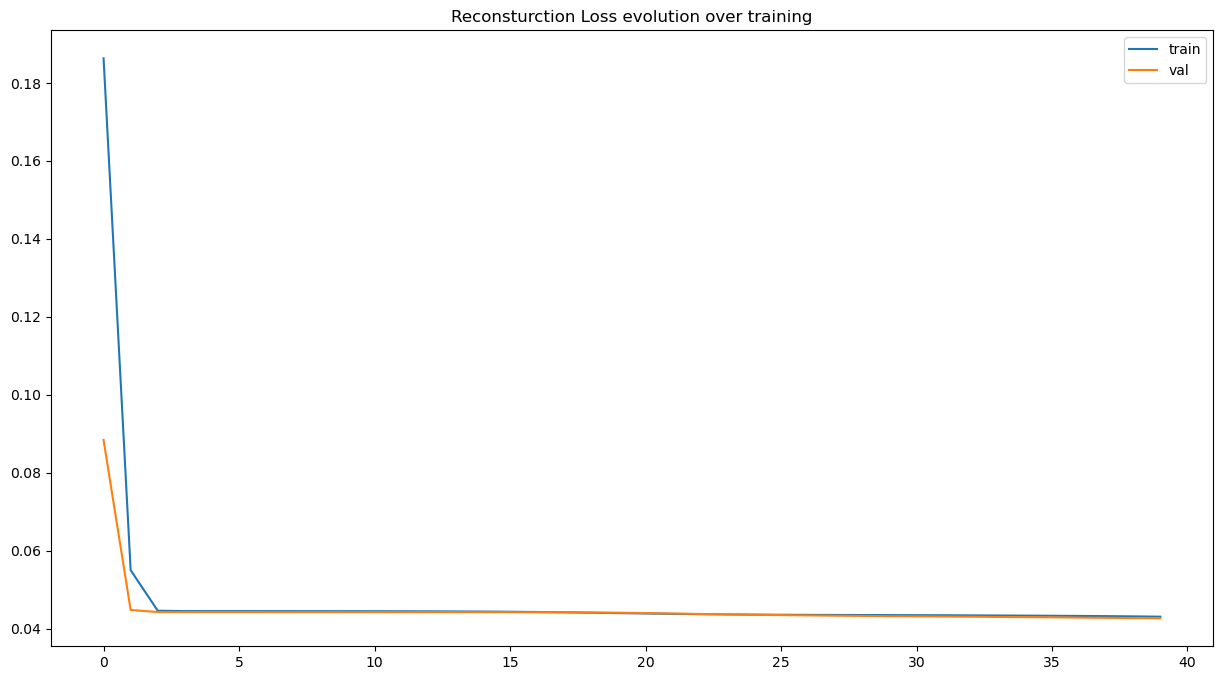

In [34]:
plt.figure(figsize=(15, 8))
plt.plot(history['train_reconstruction'], label='train')
plt.plot(history['val_reconstruction'], label='val')
plt.title("Reconsturction Loss evolution over training")
plt.legend()

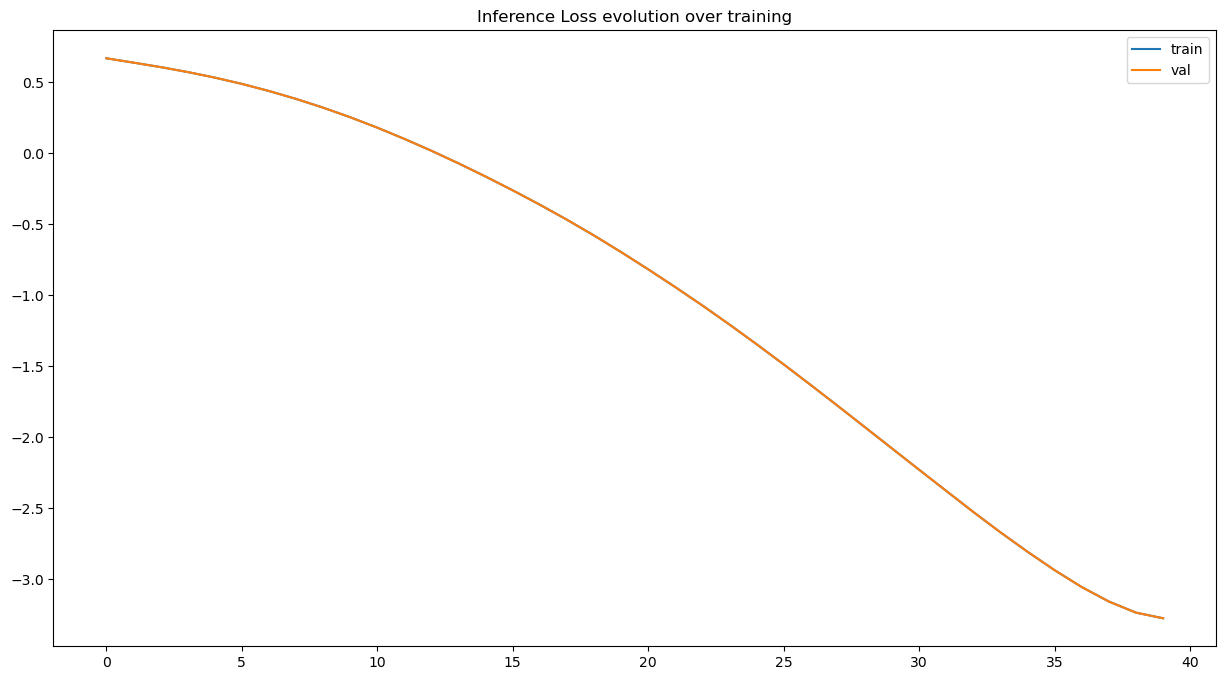

In [35]:
plt.figure(figsize=(15, 8))
plt.plot(history['train_inference'], label='train')
plt.plot(history['train_inference'], label='val')
plt.title("Inference Loss evolution over training")
plt.legend()

In [36]:
X = create_sequences(cells_actvities.T, seq_len)

X = torch.Tensor(X).to(torch.float32).to(device)

latents = irae.encoder(X).cpu().detach().numpy()

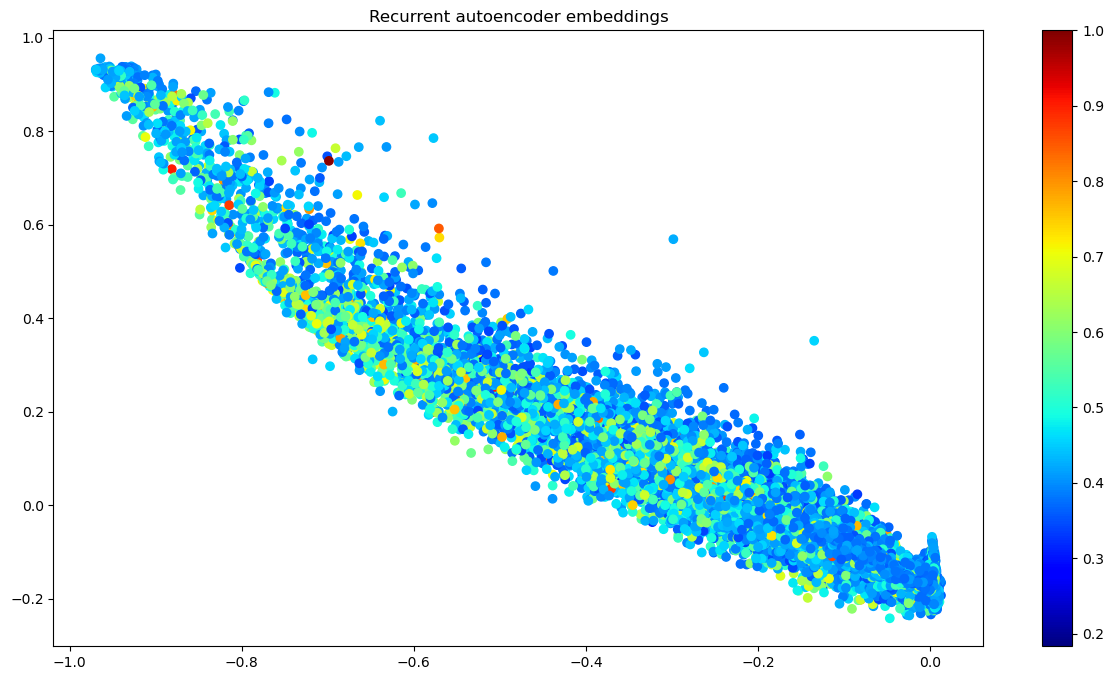

In [37]:
plt.figure(figsize=(15, 8))
plt.scatter(latents[:, 0], latents[:, 1], c=mvt_ampl[:latents.shape[0]], cmap='jet')
plt.title("Recurrent autoencoder embeddings")
plt.colorbar()

### Transformer auto encoder

In [7]:
torch.cuda.empty_cache()

# Instantiate the model
d_input = n_features
d_embedding = 256
d_hidden = 128
d_output = 2
num_blocks = 2
transformer_ae = TransformerDR(d_input, d_embedding, d_hidden, d_output, num_blocks).to(device)
#Create the optimizer of the auto encoder
optimizer = torch.optim.Adam(transformer_ae.parameters())

#Use the absolute value insteade of the square error
criterion1 = nn.L1Loss(reduction='mean').to(device)

criterion2 = nn.BCEWithLogitsLoss().to(device)

In [8]:
history = train_transformer(transformer_ae, optimizer, criterion1, criterion2,  train_tr_loader, val_tr_loader, 20, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 2  train reconstruction loss: 0.04500211402773857  val reconstruction loss: 0.044912220644099374  time: 8.909594058990479 
Epoch: 4  train reconstruction loss: 0.044955244868016636  val reconstruction loss: 0.044938517468316216  time: 8.808474063873291 
Epoch: 6  train reconstruction loss: 0.04490098963832595  val reconstruction loss: 0.04483151435852051  time: 8.903997898101807 
Epoch: 8  train reconstruction loss: 0.04483846601485555  val reconstruction loss: 0.04482354995395456  time: 8.896830797195435 
Epoch: 10  train reconstruction loss: 0.04481449641816603  val reconstruction loss: 0.044825296849012375  time: 8.822256565093994 
Epoch: 12  train reconstruction loss: 0.04478419659649088  val reconstruction loss: 0.04478380669440542  time: 9.168066024780273 
Epoch: 14  train reconstruction loss: 0.044774760354737764  val reconstruction loss: 0.04478380616222109  time: 9.237831115722656 
Epoch: 16  train reconstruction loss: 0.04474249689793978  val reconstruction loss: 0.044

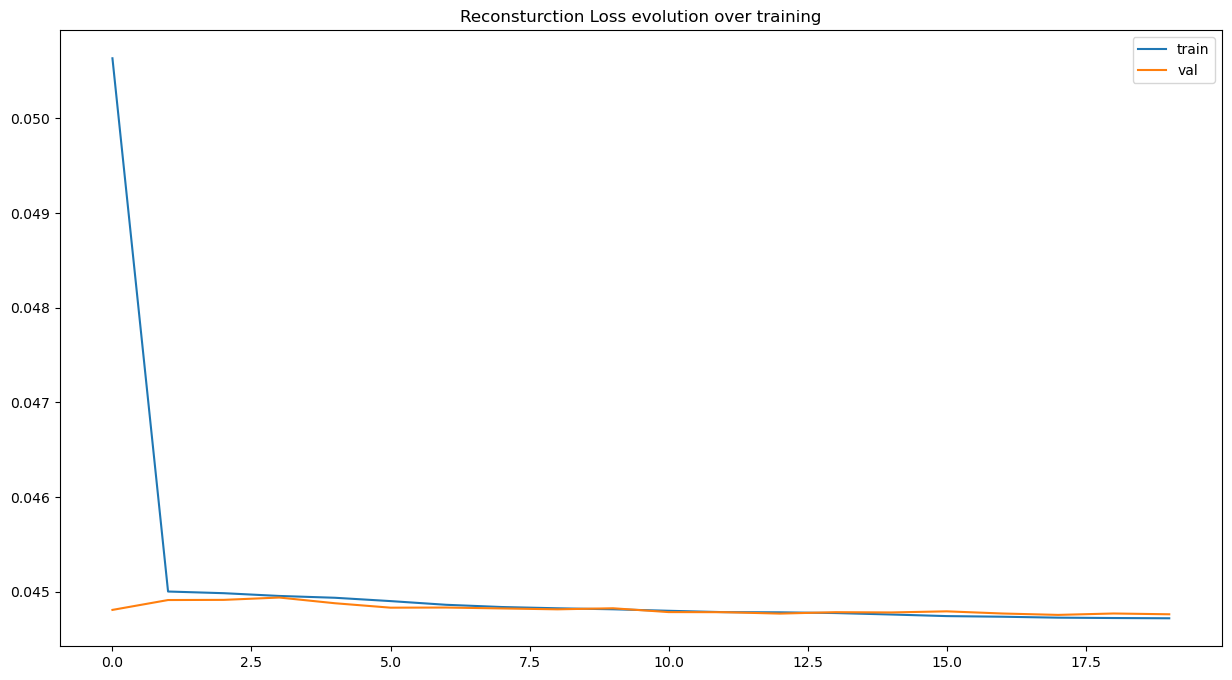

In [9]:
plt.figure(figsize=(15, 8))
plt.plot(history['train_reconstruction'], label='train')
plt.plot(history['val_reconstruction'], label='val')
plt.title("Reconsturction Loss evolution over training")
plt.legend()

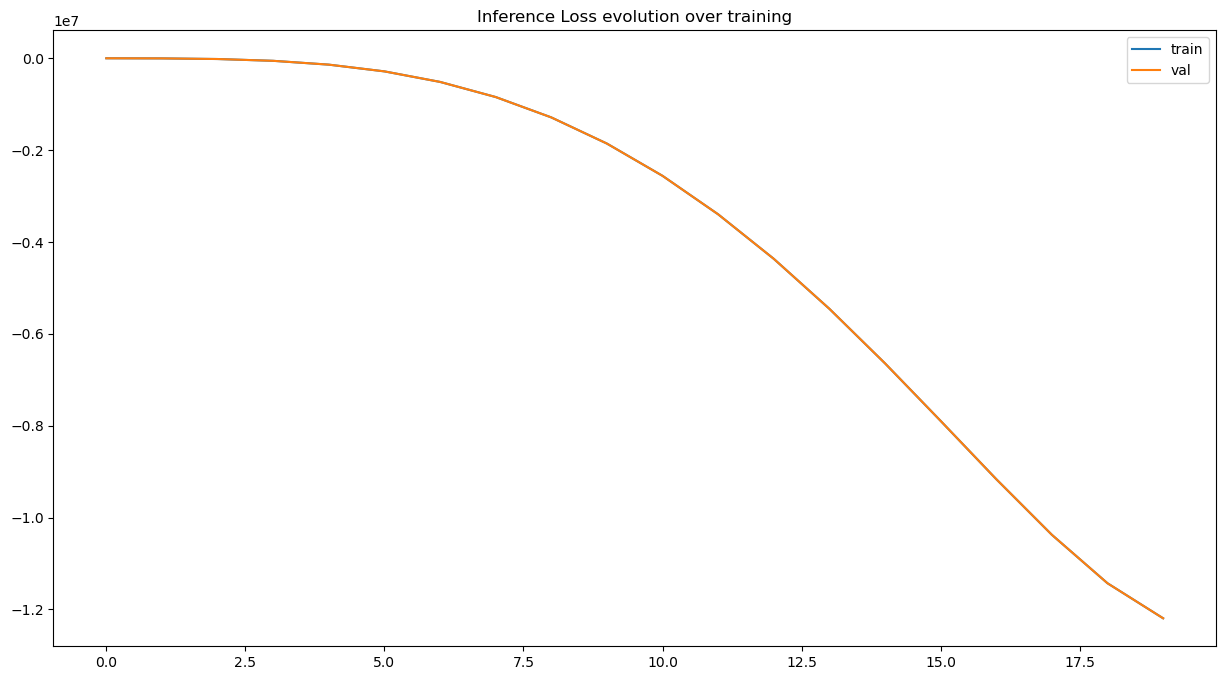

In [10]:
plt.figure(figsize=(15, 8))
plt.plot(history['train_inference'], label='train')
plt.plot(history['train_inference'], label='val')
plt.title("Inference Loss evolution over training")
plt.legend()

In [17]:
X[-1].shape

(49, 325)

In [20]:
X = np.array_split(cells_actvities.T, cells_actvities.shape[1]//49)[:-1]

In [21]:
embeddings = []

for x in X:

    x = torch.Tensor(x).to(device)

    embeddings.append(transformer_ae.encoder(transformer_ae.embedding_layer(x)).cpu().detach().numpy())

In [22]:
embeddings = np.concatenate(embeddings, axis=0)

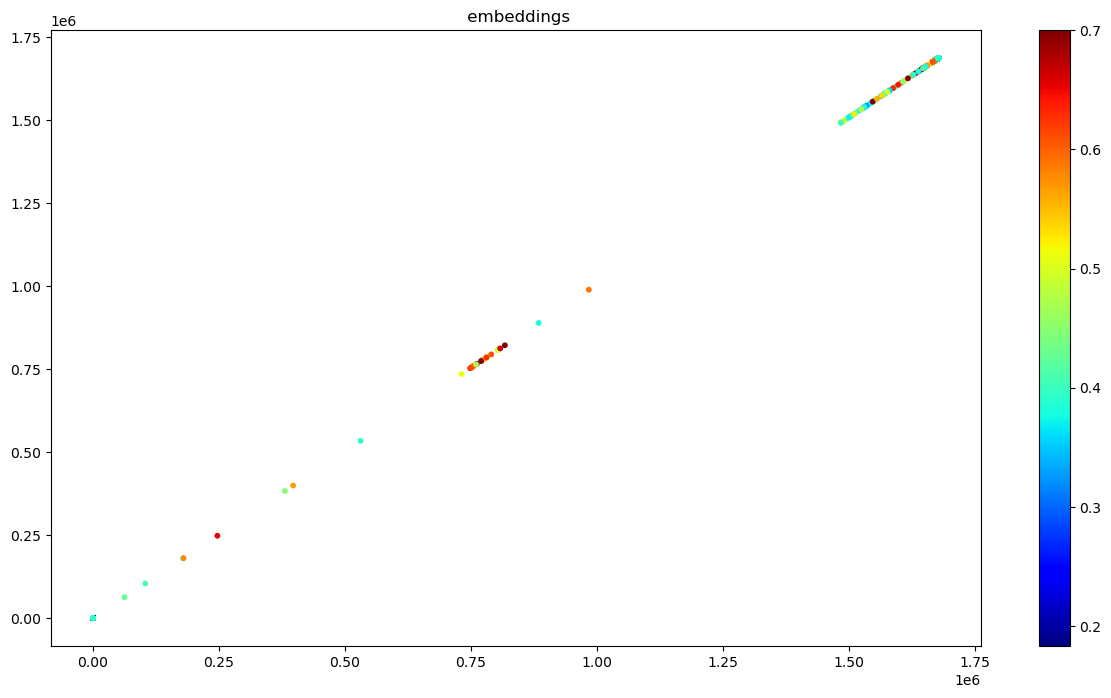

In [27]:
plt.figure(figsize=(15, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=mvt_ampl[:embeddings.shape[0]], cmap='jet', s=10, vmax=0.7)
plt.title(" embeddings")
plt.colorbar()